In [5]:
import kagglehub
uwrfkaggler_ravdess_emotional_speech_audio_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-speech-audio')

print('Data source import complete.')

Using Colab cache for faster access to the 'ravdess-emotional-speech-audio' dataset.
Data source import complete.


In [6]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import IPython.display as ipd
from IPython.display import Audio

import multiprocessing as mp
import timeit
from tqdm import tqdm

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for i in ravdess_directory_list:
    actor = os.listdir(Ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + i + '/' + f)

In [8]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
Ravdess_df['Emotions'] = Ravdess_df['Emotions'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
print(Ravdess_df.head())
print("______________________________________________")
print(Ravdess_df.tail())
print("_______________________________________________")
print(Ravdess_df.Emotions.value_counts())

   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
Emotions
neutral     288
surprise    192
disgust     192
fear        192
sad         192
happy       192
angry       192
Name: count, dty

<Axes: xlabel='Emotions'>

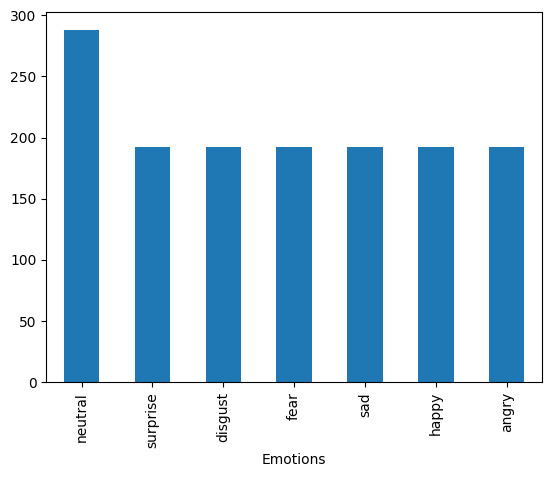

In [9]:
Ravdess_df.Emotions.value_counts().plot(kind='bar')

In [10]:
data,sr = librosa.load(file_path[0])
sr

22050

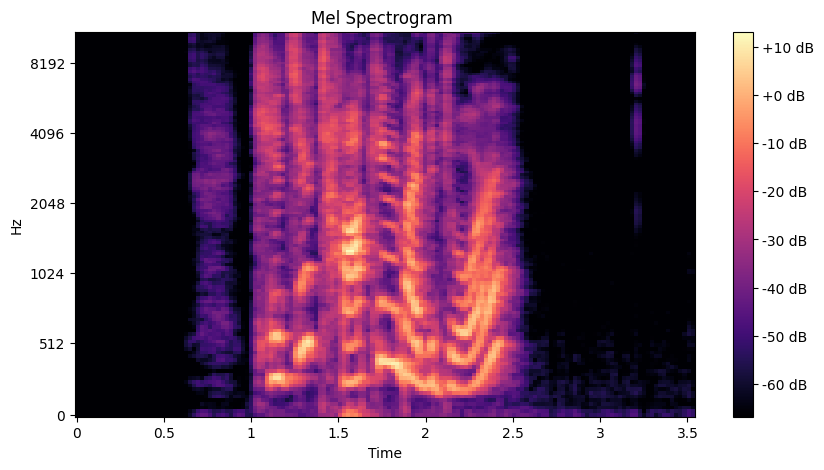

In [11]:
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time')
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

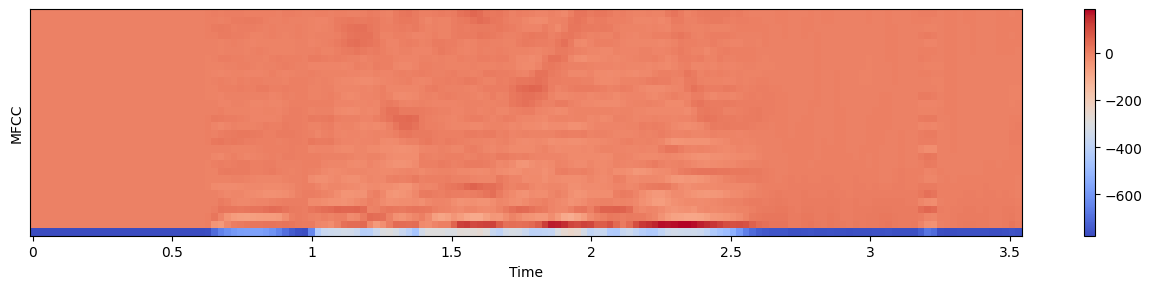

In [12]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [13]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [14]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(mfcc_result.T) if not flatten else np.ravel(mfcc_result.T)

def extract_spectrogram_features(data, sr, n_mels=128, fmax=8000):
    spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    # Flatten the spectrogram to a 1D array
    return np.ravel(log_spectrogram)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
         zcr(data,frame_length,hop_length),
         rmse(data,frame_length,hop_length),
         mfcc(data,sr,frame_length,hop_length),
         extract_spectrogram_features(data, sr)
        ))

    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio

In [15]:
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(Ravdess_df.Path,Ravdess_df.Emotions,range(Ravdess_df.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

2it [00:01,  1.55it/s]

0 audio has been processed


502it [01:49,  5.38it/s]

500 audio has been processed


1002it [03:37,  5.32it/s]

1000 audio has been processed


1440it [05:12,  4.61it/s]

Done
Time:  312.23325032700006


In [16]:
# Convert X and Y lists to NumPy arrays
# Use dtype=object to handle potentially inconsistent feature vector lengths
X_np = np.array(X, dtype=object)
Y_np = np.array(Y) # Y should be fine as it contains scalar emotion labels

# Save the arrays to .npy files
np.save('features.npy', X_np)
np.save('labels.npy', Y_np)

print("Features and labels saved to 'features.npy' and 'labels.npy'")

Features and labels saved to 'features.npy' and 'labels.npy'


In [17]:
len(X), len(Y), Ravdess_df.Path.shape

(5760, 5760, (1440,))

In [18]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,16191,16192,16193,16194,16195,16196,16197,16198,16199,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,surprise
1,0.246094,0.373047,0.479492,0.453125,0.404785,0.347168,0.308105,0.290039,0.275879,0.273438,...,-76.106436,-74.883438,-73.513839,-74.222827,-73.777520,-73.117735,-74.134359,-73.823915,-73.375890,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,surprise
3,0.255371,0.383301,0.514648,0.508789,0.504395,0.504395,0.504395,0.499023,0.499023,0.489746,...,-44.582599,-43.307854,-44.500520,-44.951995,-41.435423,-39.997675,-41.928070,-42.830639,-43.763166,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,neutral


In [19]:
Emotions.shape

(5760, 16201)

In [20]:
# Load the features and labels from the .npy files
X_loaded = np.load('features.npy', allow_pickle=True)
Y_loaded = np.load('labels.npy')

try:
    X_loaded = np.vstack(X_loaded).astype(float)
except ValueError:
    print("Warning: Feature shapes are inconsistent. PCA might not work as expected.")
    try:
        X_loaded_df = pd.DataFrame(list(X_loaded))
        X_loaded_df = X_loaded_df.dropna() # Drop rows where vstack failed due to inconsistent shapes
        Y_loaded = Y_loaded[X_loaded_df.index] # Align labels with features
        X_loaded = X_loaded_df.values.astype(float)
        print(f"Reduced to {X_loaded.shape[0]} samples after dropping inconsistent feature rows.")
    except Exception as e:
        print(f"Could not handle inconsistent shapes: {e}")
        raise

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_loaded)

# Apply PCA with all components to calculate explained variance
pca = PCA()
pca.fit(X_scaled)

n_components = 500
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print(f"Original features shape: {X_loaded.shape}")
print(f"Reduced features shape after PCA: {X_pca.shape}")

print(f"Explained variance ratio by {n_components} components: {np.sum(pca.explained_variance_ratio_)}")

Reduced to 5700 samples after dropping inconsistent feature rows.
Original features shape: (5700, 16200)
Reduced features shape after PCA: (5700, 500)
Explained variance ratio by 500 components: 0.9218155824279601


In [21]:
# Save the PCA-reduced features and labels to .npy files
np.save('features_pca.npy', X_pca)
np.save('labels_pca.npy', Y_loaded)

print("PCA-reduced features and labels saved to 'features_pca.npy' and 'labels_pca.npy'")

PCA-reduced features and labels saved to 'features_pca.npy' and 'labels_pca.npy'


In [22]:
Emotions1 = pd.DataFrame(X_pca)
Emotions1['Emotions'] = Y_loaded
Emotions1.to_csv('emotion1.csv', index=False)
Emotions1.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,Emotions
0,-65.884684,-35.178243,38.101404,-30.200552,35.057289,-5.153883,29.533186,-1.588773,-9.651186,-5.780506,...,-0.331708,0.734161,2.143200,1.624516,3.029482,-1.663520,0.083727,1.605524,-2.689837,surprise
1,-45.719300,-29.446242,31.037416,-29.401456,34.167973,-4.911666,29.452938,-2.324042,-9.010349,-6.117245,...,-0.395090,1.086527,2.344977,1.223349,2.752919,-1.108829,0.422801,1.849535,-2.026894,surprise
2,-57.209381,-42.071434,43.778761,-25.513630,31.776891,-12.163566,27.584652,-4.303415,-7.746072,-5.943620,...,-0.617730,-1.850950,2.249919,2.388428,0.037600,-0.516229,0.936772,1.688006,-3.675679,surprise
3,110.053906,-23.185070,16.963946,-8.664025,18.780537,-9.522318,16.575035,-5.048251,-3.639624,-2.819091,...,-0.335427,-0.998612,1.439881,0.828287,-0.188977,0.517193,-0.070124,-0.108791,-2.006490,surprise
4,-75.200161,-1.148727,37.744159,13.962108,34.443483,-0.732024,-32.499937,-15.235384,8.365874,-12.893776,...,-2.116162,-1.077438,-0.912465,-1.084327,-0.703561,-1.366899,-0.801393,1.285851,1.501619,neutral
